# PyTorch 线性模型实践

有一组对未知温度单位到摄氏温度的映射数据，但当中存在一些噪声数据，需要排除这些噪声数据，并预测出近似的刻度值

In [1]:
import torch
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

在这里， `t_c` 值是以摄氏度为单位的温度，而 `t_u` 值是未知的单位。可以预期的是两组数据中的噪声来自设备本身和近似的刻度值。

## 模型准备

### 可视化数据

In [2]:
! pip install matplotlib

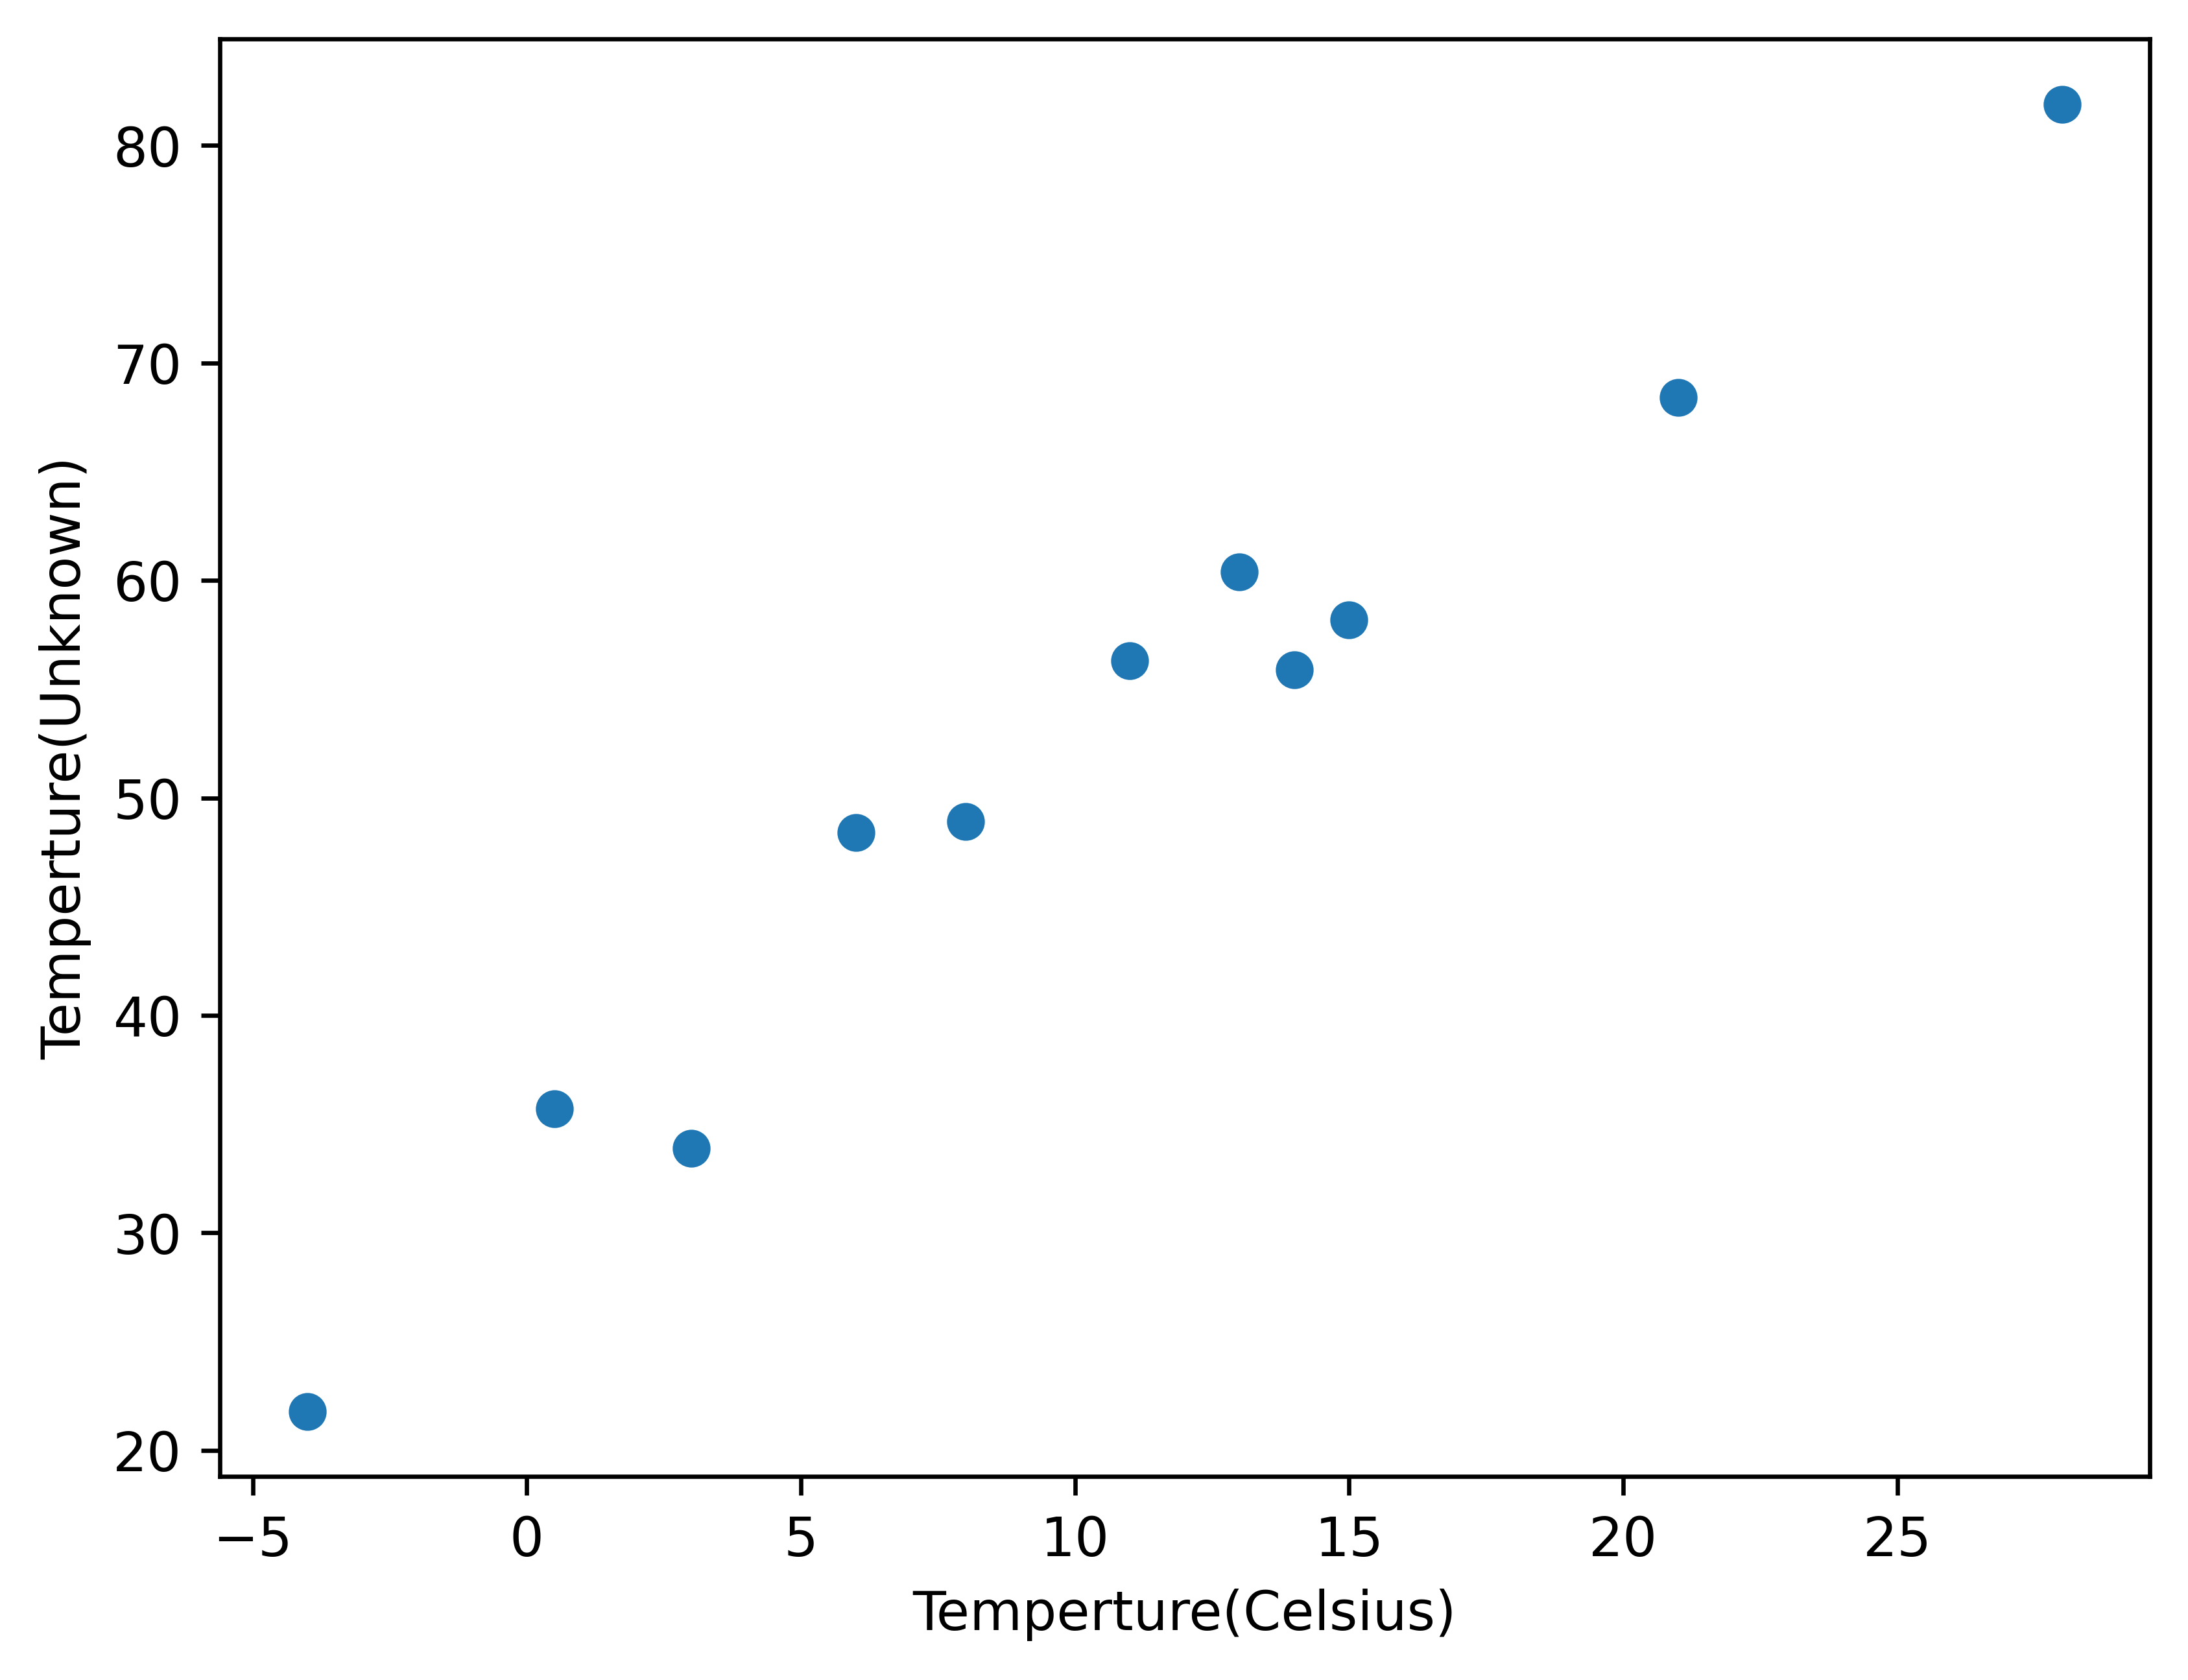

In [3]:
from matplotlib import pyplot as plt
plt.figure(dpi=600)
plt.xlabel("Temperture(Celsius)")
plt.ylabel("Temperture(Unknown)")
plt.plot(t_c.numpy(), t_u.numpy(), 'o')

从可视化数据出的图像可以看出数据整体是有规律的，但是存在噪声。

### 选择模型

在缺乏进一步了解的情况下，按照之前的可视化数据结果可以推测两个数据集是线性相关的————也就是说，将 `t_u` 乘一个因子，再加上一个长度就可以得到摄氏温度（忽略一定的误差）。

`t_c = w * t_u + b`

在上面的线性模型中，分别将权重和偏置名为 `w` 和 `b` ，现在就需要基于现有的数据来评估模型中的 `w` 和 `b` 参数。

目前我们有一个带有一些未知参数的模型，我们需要估计这些参数，使预测值和测量值之间的误差尽可能的小。预测值和测量值之间的误差也需要精确的定义，这种函数一般都被称为**损失函数**，如果误差很大，则说明损失函数的值大了。理想情况下应尽可能使损失函数的值交小，这样预测值和测量值二者可以完美匹配。因此，我们的优化过程应该是以找到 `w` 和 `b` 为目标，使损失函数的值处于最小值。

## 损失函数

**损失函数**（或代价函数）是一个计算单个数值的函数，学习过程将试图使其值最小化。损失的计算通常涉及一些*训练样本的期望输出*与*输入这些样本时模型实际产生的输出*之间的差值。在我们的这个个例子中，它将是模型输出的预测温度 `t_p` 与实际测量值之间的差值，即 `t_p-t_c`。

### 选取合适的损失函数

我们需要确保损失函数在 `t_p` 大于或小于真正的 `t_c` 时损失都为正，因为我们的目标时让 `t_p` 匹配 `t_c` (`t_p` 和 `t_c` 的差值尽可能的小)。目前有两个最直接的选择： `|t_p - t_c|` 和 `(t_p - t_c)^2` 。这两个损失函数在零点处都有一个明显的最小值，并且随着预测值在两个方向上远离真实值而单调递增。另外绝对值在收敛的地方存在一个不明确的导数，虽然这并不是什么大问题，但目前还是选在第二个平方差作为损失函数。另外，平方差比绝对差对错误结果的惩罚更大，通常有更多轻微错误的结果比有少量严重错误的结果更好。

接下来先定义模型函数：

In [4]:
def model(t_u, w, b):
    return w * t_u + b

我们期望 `t_u` 、 `w` 和 `b` 分别作为输入张量、权重参数和偏置参数。在我们的模型中，参数是 `PyTorch` 标量（也称为 0 维张量），通过乘积运算和广播生成返回的张量。接下来就要确定损失函数了：

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

在这个损失函数中，先构建了一个差分张量，然后对其值进行平方处理，最后通过对得到的张量中的所有元素求一次平均值得到一个标量损失函数，即均方损失函数。

我们现在可以初始化参数，调用模型：

In [6]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

检查损失的值

In [7]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## 梯度下降

### 更新步骤

梯度下降的基本思想是计算各参数的损失变化率，并在减小损失变化率的方向上修改各参数。我们可以通过在 `w` 和 `b` 上加一个小数字来估计变化率，然后看看损失在这附近的变化有多大。

In [8]:
delta = 0.1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

上面代码的含义是：在当前的 `w` 和 `b` 的值附近， `w` 的变化会导致损失的一些变化。如果变化是负的，那么就需要增加 `w` 的值，如果变化是正的，那么就需要减小 `w` 的值。那么值具体增加或减少多少呢？对 `w` 运用一个与损失成比例的变化是一个很好的主意。一般来说，缓慢的改变参数也是明智的，因为在距离当前 `w` 值邻域很远的地饭，损失变化的速率可能显著不同，因此，我们通常用一个很小的比例因子来衡量变化率，这个因子有很多名称，在机器学习中被称为学习率：

In [9]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

我们可以对 `b` 采用与 `w` 相同的处理方式

In [10]:
loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

以上操作表示梯度下降基本参数的更新步骤。重复上面的步骤，我们将收敛到给定数据上使损失最小的参数的最优值。但这个方法相当粗糙，接下来看看更好的方式。

### 更好的梯度下降